The problem statement:
https://gym.openai.com/envs/MsPacman-v0

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import random
import torch
from torchvision import transforms

import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent_pacman_3d import Agent
from myWrappers import StackEnv

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
# Original Gym Env basic info
env = gym.make('MsPacman-v0')
env.seed(0)
state_space = env.observation_space.shape
action_space = env.action_space.n
input_shape = (84,84)
states_stack_depth = 4
print('State shape: ', state_space)
print('Number of actions: ', action_space)

State shape:  (210, 160, 3)
Number of actions:  9


In [21]:
#to get all the preprosing logic done in this class
from myWrappers import StackEnv
stackenv = StackEnv(gym.make('MsPacman-v0'))

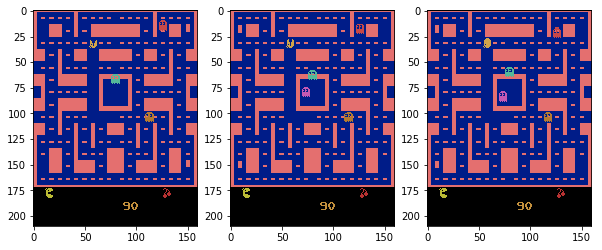

In [20]:
#import images
s = env.reset()
s0, s1, s2 = None, None, None

sampleframe = 240

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6)) 
for i in range(1000):
    s, r, d, _ = env.step(1)
    if i == sampleframe:
        s0 = s
    if i == (sampleframe+1):
        s1= s
    if i == (sampleframe+2):
        s2= s
ax1.imshow(s0)
ax2.imshow(s1)
ax3.imshow(s2)

In [25]:
s = stackenv.reset()
ns, r, d = stackenv.step(0)
print(ns.shape)

(4, 84, 84)


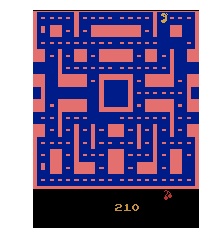

In [26]:
untrained_agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=10)

# watch an untrained agent

state_inputs = stackenv.reset()

img = plt.imshow(stackenv.env.render(mode='rgb_array'))
for j in range(1000):
    action = untrained_agent.act(state_inputs)
    img.set_data(stackenv.env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    next_state_inputs, reward, done = stackenv.step(action)
    state_inputs = next_state_inputs
    
    if done:
        break 
        
env.close()

In [10]:
def loadTrainedModel(agent, path):
    state_dicts = torch.load(path)
    print(state_dicts['model'].keys())

    agent.qnetwork_local.load_state_dict(state_dicts['model'])
    agent.optimizer.load_state_dict(state_dicts['optimizer'])

In [11]:
def saveTrainedModel(agent, path):
    state_dicts = {'model': agent.qnetwork_local.state_dict(), 'optimizer': agent.optimizer.state_dict()}
    torch.save(state_dicts, path)

In [12]:
model_dir = 'saved_models/'
model_name = 'MsPacman-3D-all-dicts-AWS.pt'

agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=0)

loadTrainedModel(agent, model_dir+model_name)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


Episode 100	Average Score: 217.70	eps: 0.95
Episode 200	Average Score: 242.40	eps: 0.90
Episode 300	Average Score: 238.60	eps: 0.86
Episode 400	Average Score: 234.90	eps: 0.82
Episode 500	Average Score: 245.60	eps: 0.78


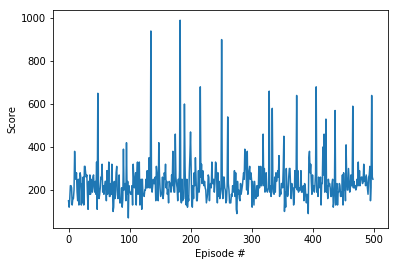

In [13]:
model_dir = 'saved_models/'
model_name = 'MsPacman-v0-3D-all-dicts-AWS.pt'

def dqn_3D(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.9995, skipframe_max=4):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    frame_counter = 0                  # keep track of number of frames seen
    
    eps = eps_start                    # initialize epsilon 
    eps_decay=1-1/(1000+500)           # make sure decay come to min 
    
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        
        #stack to keep track of most recent states
        states_stack = deque([torch.zeros(input_shape) for z in range(states_stack_depth)], maxlen=states_stack_depth)
        
        state_inputs = state2StackedInputs(states_stack, state, np.zeros(state.shape, dtype=np.uint8))
        #state_inputs = state2StackedInputs(states_stack, state)
        
        last_state = state

        score = 0
        skip_counter = 0
        for t in range(max_t):

            action = agent.act(state_inputs, eps) #for action recommendation
            
            next_state, reward, done, _ = env.step(action)
            frame_counter += 1

            next_state_inputs = state2StackedInputs(states_stack, next_state, last_state)

            
            if skip_counter >= skipframe_max:
                agent.step(state_inputs , action, reward, next_state_inputs, done)
                skip_counter = 0
            else:
                skip_counter += 1

            state_inputs = next_state_inputs
            last_state = next_state
            
            score += reward
            if done and skip_counter==0:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode: {}\tAvg Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            latest_lr = agent.optimizer.state_dict()['param_groups'][0]['lr']
            
            print(('\rEpisode: {}\tAvg Score: {:.2f}\tsteps: {}'
                   '\tlr: {:1.2e}\tp: {:.3f}  b: {:.3f}').format(i_episode, np.mean(scores_window),
                                                                 agent.t_step,latest_lr, 
                                                                 agent.p_discount, 
                                                                 agent.sampling_bias, end="")) 

            saveTrainedModel(agent, model_dir+model_name)
        
        if np.mean(scores_window)>=1000.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            
            saveTrainedModel(agent, model_dir+model_name)
            break
        
    return scores

scores = dqn_3D(3000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
saveTrainedModel(agent, model_dir+model_name)

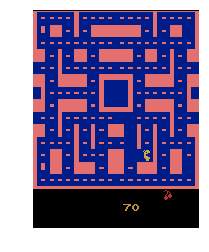

In [20]:
# load the weights from file
#torch.load(agent.qnetwork_local.state_dict(), model_dir+model_name)
agent.qnetwork_local.eval()
agent.qnetwork_target.eval()

for i in range(3):
    # watch an untrained agent
    states_stack = deque([torch.zeros(input_shape) for z in range(states_stack_depth)], maxlen=states_stack_depth)

    state = env.reset()
    state_inputs = state2StackedInputs(states_stack, state)
    last_state = state
    
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(1000):
        action = agent.act(state_inputs)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        next_state, reward, done, _ = env.step(action)
        
        next_state_inputs = state2StackedInputs(states_stack, next_state, last_state)
        state_inputs = next_state_inputs
        last_state = next_state
        
        if done:
            break 

agent.qnetwork_local.train()
agent.qnetwork_target.train()
            
env.close()